<a href="https://colab.research.google.com/github/Waleed-Mujahid/Facial-Expression-Classifier/blob/main/Emotion_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion classifier from Facial Data
  In this notebook I will make an emotion classifier from facial expression dataset from kaggle using CNN's in tensorflow.

## Importing dependecies
First we import our neccessary dependecies and helper functions


In [3]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, InputLayer
# from keras.engine.input_layer import InputLayer
import matplotlib.pyplot as plt
import keras
import numpy as np

Here I import helper functions to improve reusability of code.

In [4]:
!wget https://raw.githubusercontent.com/Waleed-Mujahid/Python/master/colabUtils.py

--2022-07-01 08:30:40--  https://raw.githubusercontent.com/Waleed-Mujahid/Python/master/colabUtils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625 (1.6K) [text/plain]
Saving to: ‘colabUtils.py.1’

colabUtils.py.1     100%[===================>]   1.59K  --.-KB/s    in 0s      

2022-07-01 08:30:40 (35.2 MB/s) - ‘colabUtils.py.1’ saved [1625/1625]



In [5]:
from colabUtils import *

## Loading our Dataset from Kaggle

In [6]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


First you need to download your API credentials from kaggle. You will get a kaggle.json file. Upload it below

In [8]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [9]:
! cp kaggle.json ~/.kaggle/

In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
! kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 93% 112M/121M [00:00<00:00, 131MB/s] 
100% 121M/121M [00:00<00:00, 144MB/s]


In [ ]:
# next we unzip the data
!unzip /content/face-expression-recognition-dataset.zip

Finally our dataset has been loaded into our Colab session. Now we are able to load into a suitable dataframe to train our model

In [13]:
# Path to the Train and validation datasets

train_data_dir = '/content/images/images/train'
validation_data_dir = '/content/images/images/validation'

## Visualizing our Data
Next we look at our data to help us understand it.

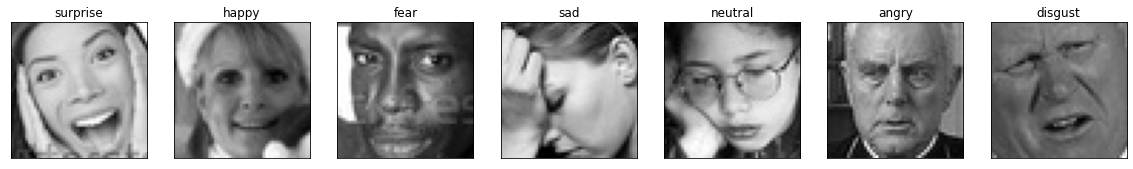

In [14]:
import os, random
from PIL import Image 

plt.figure(figsize = (20,7))
count = 1

for folder in os.listdir(train_data_dir):
  path = train_data_dir + '/' + folder
  img = random.choice(os.listdir(path))
  img_path = path + '/' + img
  plt.subplot(1,7,count)
  img = Image.open(img_path)    # Visualizing the image
  img.load()
  plt.xticks([])             # Disabling ticks
  plt.yticks([])
  plt.title(folder)
  plt.imshow(img, cmap = 'gray')
  count += 1  
  img_width, img_height = img.size

## Building our Model
### Pre-processing our data
Before we can train our model, we must process our data. Here we make use of keras' ImageDataGenerator to generate batches of augmented data. Data augmentation can help tackle overfitting.

In [15]:
train_datagen = ImageDataGenerator( 
rescale=1. / 255,
rotation_range = 20,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1. / 255
)

In [16]:
train_generator = train_datagen.flow_from_directory(
train_data_dir,
batch_size = 32,
target_size=(img_width, img_height),
color_mode="grayscale",
)

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
batch_size = 128,
color_mode="grayscale",
target_size=(img_width, img_height),
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


Here we use ImageDataGenerator's attribute class indices to get our class labels (folder names in our dataset). We will make use of this when we are making predictions on unseen data.

In [17]:
labels = validation_generator.class_indices
labels = {value:key for key, value in labels.items()}

### Creating our model in Keras

In [18]:
layer_counter = 0

In [19]:
def convBlock(channels,filter_size,dropout_rate,activation = 'relu', padding = 'same', max_pool_strides = 2):
  global layer_counter
  block = Sequential(name = f"Block_{layer_counter}")
  layer_counter += 1
  block.add(Conv2D(channels, (filter_size, filter_size), padding= padding ))  # Input size of all images must be standard for model
  block.add(BatchNormalization())
  block.add(keras.layers.Activation(activation))
  block.add(MaxPooling2D(strides = max_pool_strides ))
  block.add(Dropout(dropout_rate))
  return block

In [41]:
# Building our model in Keras
drop_rate = 0.3

model = Sequential()
model.add(InputLayer(input_shape=(img_width, img_height,1)))
model.add(convBlock(channels = 32, filter_size = 5, dropout_rate = drop_rate))
model.add(convBlock(channels = 64, filter_size = 5, dropout_rate = drop_rate))
model.add(convBlock(channels = 128, filter_size = 3, dropout_rate = drop_rate))
model.add(convBlock(channels = 256, filter_size = 3, dropout_rate = drop_rate))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(drop_rate))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(drop_rate))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(drop_rate))
model.add(Dense(7, activation='softmax')) 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Block_8 (Sequential)        (None, 24, 24, 32)        960       
                                                                 
 Block_9 (Sequential)        (None, 12, 12, 64)        51520     
                                                                 
 Block_10 (Sequential)       (None, 6, 6, 128)         74368     
                                                                 
 Block_11 (Sequential)       (None, 3, 3, 256)         296192    
                                                                 
 flatten_2 (Flatten)         (None, 2304)              0         
                                                                 
 dense_8 (Dense)             (None, 1024)              2360320   
                                                                 
 batch_normalization_18 (Bat  (None, 1024)            

### Callbacks
Next up we add early stopping callback to our model. This will stop the training if the validation loss has not decreased after 10 epochs (see patience = 10). This will help us avoid overfitting 

In [43]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode = 'min',
    verbose=1,
    patience = 10,
    restore_best_weights=True,
)

### Compile and Training our Model
  Next up we train our model. We are using Adma optimizer and Categircal crossentropy which is standard for one hot encoded data. We train for 100 epochs and pass Early stopping as callback

In [44]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
metrics=['accuracy'])

In [ ]:
history = model.fit(
train_generator,
epochs= 100,
validation_data=validation_generator,
batch_size = 32,
callbacks = [es]
) 

### Visualizing our Model's training
  Now we use the helper functions imported to look at how our model has trained.

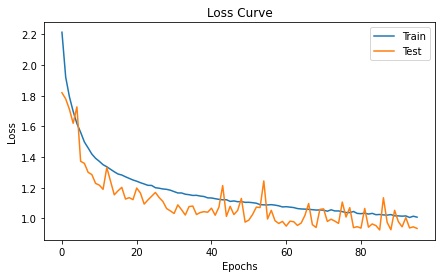

In [48]:
plotLoss(history,True)

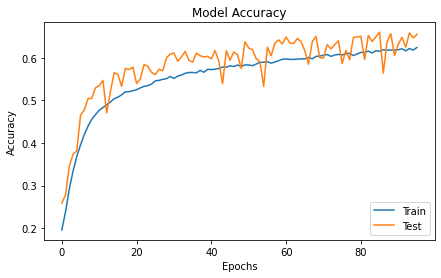

In [49]:
plotAccuracy(history,True)

### Evaluating our model
Next we look at the accuacy acheived by our model on the Validation dataset

In [50]:
loss, accuracy = model.evaluate(validation_generator)

56/56 [==============================] - 2s 30ms/step - loss: 0.9244 - accuracy: 0.6599


In [51]:
print(f'So our model has acheived {accuracy*100:.02f} % accuracy on the validation dataset.')

So our model has acheived 65.99 % accuracy on the validation dataset.


## Summing up our Results 
Lastly we take some random images from the internet to see how our model perform on real world data.

In [89]:
!git clone https://github.com/Waleed-Mujahid/Facial-Expression-Classifier

Cloning into 'Facial-Expression-Classifier'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [103]:
paths = []
dir = '/content/Facial-Expression-Classifier/'

for files in os.listdir(dir):
  paths.append(dir + files)

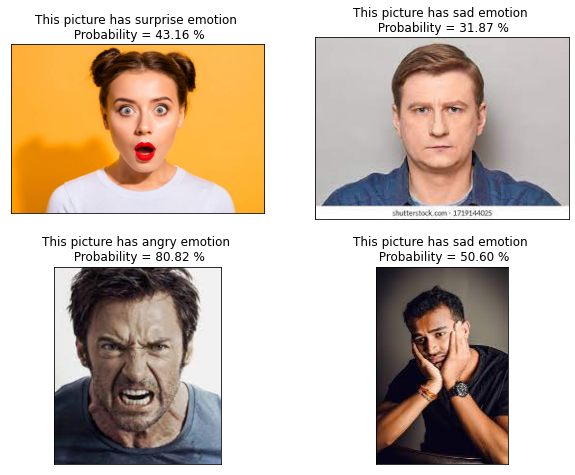

In [129]:
count = 1
plt.figure(figsize=(10,8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

for path in paths[:-1]:
  plt.subplot(2,2,count)  
  count +=1
  _img = Image.open(path)    # Visualizing the image
  _img.load()
  plt.xticks([])             # Disabling ticks
  plt.yticks([])
  plt.imshow(_img)

  # Converting the image so it can be fed into the model
  img = tf.io.read_file(path)
  img = tf.image.decode_image(img)
  test_img = tf.image.resize(img, size = (img_width,img_height))    # Resize the image according to the model
  test_img = tf.image.rgb_to_grayscale(test_img)                     # Model expects a grayscale image
  test_img = test_img/255.                                           # Normalizing the image

  pred = model.predict(tf.expand_dims(test_img,axis = 0))
  val = np.argmax(pred,axis=1)
  emotion = labels[val[0]]
  plt.title(f'This picture has {emotion} emotion \n Probability = {pred.max()*100:.02f} %')

So our classifier got 3 out of 4 test examples right.

Let us check the wrongfully evaluated image in detai.

In [127]:
path = paths[1]
img = tf.io.read_file(path)
img = tf.image.decode_image(img)
test_img = tf.image.resize(img, size = (img_width,img_height))    # Resize the image according to the model
test_img = tf.image.rgb_to_grayscale(test_img)                     # Model expects a grayscale image
test_img = test_img/255.                                           # Normalizing the image

pred = model.predict(tf.expand_dims(test_img,axis = 0))
val = np.argmax(pred,axis=1)
print(f'Confidence for {labels[4]} = {pred[0][4]*100:.02f} % \nConfidence for {labels[5]} = {pred[0][5]*100:.02f} %')

Confidence for neutral = 28.87 % 
Confidence for sad = 31.87 %


So we can see that the model was not off by too much. Its 2nd most probable prediction was right. which is very close to the most probable one.

## Saving our model
Last we save our model so can use it later on.

In [130]:
model_json = model.to_json()
with open("facial_expression_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("facial_expression_model.h5")